In [1]:
import pandas as pd

In [2]:
data_path='/content/data/raw/HIV.csv'
data=pd.read_csv(data_path)

In [21]:
data.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [ ]:
pip install rdkit


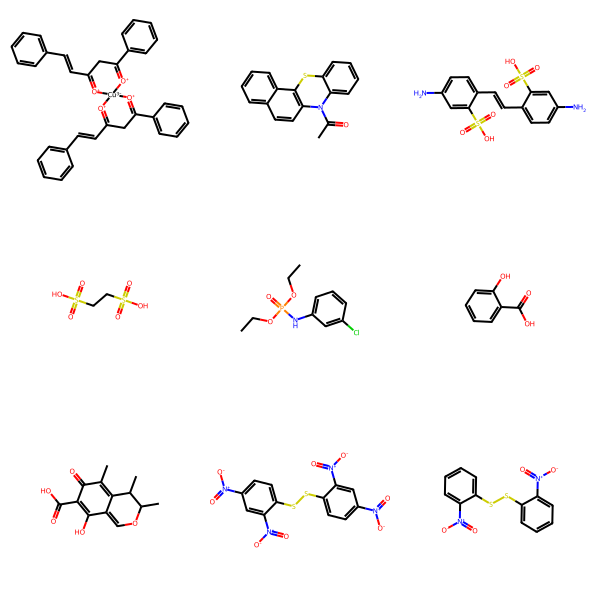

In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
sample_smiles=data['smiles'][1:10].values
sample_mols=[Chem.MolFromSmiles(smiles) for smiles in sample_smiles]
Draw.MolsToGridImage(sample_mols)

In [ ]:
!pip install torch torchvision

In [ ]:
!pip install torch-geometric

In [8]:
import torch
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from rdkit import Chem

class MoleculeDataset(Dataset):
    def __init__(self, root, test=False, transform=None, pre_transform=None, pre_filter=None):
        self.test = test
        super(MoleculeDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return 'HIV.csv'

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats,
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        )
            if self.test:
                torch.save(data,
                    os.path.join(self.processed_dir,
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data,
                    os.path.join(self.processed_dir,
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir,
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                 f'data_{idx}.pt'))
        return data


In [11]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        embedding_size = model_params["model_embedding_size"]
        n_heads = model_params["model_attention_heads"]
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        top_k_ratio = model_params["model_top_k_ratio"]
        self.top_k_every_n = model_params["model_top_k_every_n"]
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size,
                                    embedding_size,
                                    heads=n_heads,
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True)

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size,
                                                    embedding_size,
                                                    heads=n_heads,
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))


        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))
        self.linear3 = Linear(int(dense_neurons/2), 1)

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))

        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x


In [15]:
import pandas as pd

# Load raw dataset
data = pd.read_csv("data/raw/HIV.csv")

# Check the class distribution before oversampling
print("Class distribution before oversampling:")
print(data["HIV_active"].value_counts())

# Apply oversampling
neg_class = data["HIV_active"].value_counts()[0]
pos_class = data["HIV_active"].value_counts()[1]
multiplier = (neg_class // pos_class)

# Replicate the dataset for the positive class
replicated_pos = pd.concat([data[data["HIV_active"] == 1]] * multiplier, ignore_index=True)

# Append replicated data to the original dataset
data_balanced = pd.concat([data, replicated_pos], ignore_index=True)

# Shuffle dataset
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# Re-assign index (This is our ID later)
data_balanced.index = range(data_balanced.shape[0])
data_balanced["index"] = data_balanced.index

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(data_balanced["HIV_active"].value_counts())

# Halve the dataset to ensure equal distribution
half_samples = min(neg_class, pos_class * multiplier) // 2

# Sample half from each class
data_neg = data_balanced[data_balanced["HIV_active"] == 0].sample(half_samples)
data_pos = data_balanced[data_balanced["HIV_active"] == 1].sample(half_samples)

# Combine the sampled data
data_final = pd.concat([data_neg, data_pos], ignore_index=True)

# Shuffle the final dataset
data_final = data_final.sample(frac=1).reset_index(drop=True)

# Re-assign index (This is our ID later)
data_final.index = range(data_final.shape[0])
data_final["index"] = data_final.index

# Check the class distribution after halving
print("Class distribution after halving:")
print(data_final["HIV_active"].value_counts())

# Save the final dataset
data_final.to_csv("data/raw/HIV.csv", index=False)


Class distribution before oversampling:
HIV_active
0    39684
1     1443
Name: count, dtype: int64
Class distribution after oversampling:
HIV_active
1    40404
0    39684
Name: count, dtype: int64
Class distribution after halving:
HIV_active
0    19480
1    19480
Name: count, dtype: int64


In [18]:
pip install mlflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [19]:
import mlflow
import mlflow.pytorch
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Prepare the dataset
dataset = MoleculeDataset(root='data/')
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model parameters
model_params = {
    "model_embedding_size": 128,
    "model_attention_heads": 8,
    "model_layers": 4,
    "model_dropout_rate": 0.2,
    "model_top_k_ratio": 0.8,
    "model_top_k_every_n": 1,
    "model_dense_neurons": 256,
    "model_edge_dim": 2  # Adjust this based on the actual number of edge features
}

# Initialize the model
feature_size = 9  # Adjust this based on the actual number of node features
model = GNN(feature_size, model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training loop parameters
num_epochs = 20

# Start an MLflow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params(model_params)
    mlflow.log_param("feature_size", feature_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("learning_rate", 0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            x, edge_attr, edge_index, batch_index, y = batch.x, batch.edge_attr, batch.edge_index, batch.batch, batch.y
            y = y.view(-1, 1).float()  # Ensure y is of shape (batch_size, 1) and float
            out = model(x, edge_attr, edge_index, batch_index)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                x, edge_attr, edge_index, batch_index, y = batch.x, batch.edge_attr, batch.edge_index, batch.batch, batch.y
                y = y.view(-1, 1).float()
                out = model(x, edge_attr, edge_index, batch_index)
                pred = (torch.sigmoid(out) > 0.5).float()
                correct += (pred == y).sum().item()
                total += y.size(0)

        accuracy = correct / total
        average_loss = running_loss / len(train_loader)

        # Log metrics
        mlflow.log_metric("train_loss", average_loss, step=epoch)
        mlflow.log_metric("accuracy", accuracy, step=epoch)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy}')

    # Log the model
    mlflow.pytorch.log_model(model, "model")

print("Training complete!")


Processing...
 11%|█▏        | 4443/38960 [00:07<01:11, 481.72it/s][02:33:44] WARNING: not removing hydrogen atom without neighbors
[02:33:44] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 38960/38960 [01:03<00:00, 611.19it/s]
Done!


Epoch 1/20, Loss: 0.7017648829571765, Accuracy: 0.4960215605749487
Epoch 2/20, Loss: 0.6900604282194095, Accuracy: 0.5487679671457906
Epoch 3/20, Loss: 0.6897238708986638, Accuracy: 0.5494096509240246
Epoch 4/20, Loss: 0.6923876280534929, Accuracy: 0.49499486652977415
Epoch 5/20, Loss: 0.6925409883566706, Accuracy: 0.49974332648870634
Epoch 6/20, Loss: 0.6926460062943445, Accuracy: 0.5422227926078029
Epoch 7/20, Loss: 0.69336722818733, Accuracy: 0.4960215605749487
Epoch 8/20, Loss: 0.6934638512330379, Accuracy: 0.4960215605749487
Epoch 9/20, Loss: 0.6933879752545876, Accuracy: 0.4960215605749487
Epoch 10/20, Loss: 0.6932668406248582, Accuracy: 0.4961498973305955
Epoch 11/20, Loss: 0.693201490129044, Accuracy: 0.5052618069815195
Epoch 12/20, Loss: 0.693266272055295, Accuracy: 0.4960215605749487
Epoch 13/20, Loss: 0.6932251659017324, Accuracy: 0.4960215605749487
Epoch 14/20, Loss: 0.6933206861391205, Accuracy: 0.4947381930184805
Epoch 15/20, Loss: 0.6932754254071865, Accuracy: 0.53477926

2024/07/10 04:55:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 20/20, Loss: 0.693233251632851, Accuracy: 0.4961498973305955


2024/07/10 04:55:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Training complete!


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
